## Milestone 2: Data Analysis and Visualization

By: Eric Zack and Daniel Nour

## Overview
In this milestone, we work with Data Analysis and Visualization aspects of our project aimed at verifying the accuracy of 500mb geopotential heights forecasted by the ECMWF operational model. We compare these forecasts against verification data over varying time frames, analyze multiple model runs, and perform comparisons with another model (GFS) and climatological data from ERA5.

In [31]:
# Import necessary Libraries
from herbie import Herbie, FastHerbie
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import cdsapi
import os
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from sklearn.metrics import mean_squared_error
import math
import shutil

In [32]:
run = pd.Timestamp("now", tz="utc").replace(tzinfo=None).floor('24h')
timelist = pd.date_range(start='2024-10-01', end='2024-10-11', freq='6h')
newlist = list(timelist)  

ss = r":gh:500:"

H = FastHerbie(timelist, model="ifs", product="oper", fxx=[0])

Hforecastfull = FastHerbie(newlist[:1], model="ifs", product="oper", fxx=[0,12,24,36,48,60,72,84,96,108,120,132,144,156,168,180,192,204,216,228,240])
df = Hforecastfull.inventory()
df.reference_time.unique()

ds3 = Hforecastfull.xarray(ss)
ds3 = ds3.sortby(['latitude', 'longitude'])
ds3 = ds3.sel(longitude=slice(-130, -60), latitude=slice(20,60))

latitude = ds3['latitude']
longitude = ds3['longitude']
valid_time = ds3['valid_time']
forecastfull = ds3['gh']
forecastfull = forecastfull.sortby(['latitude', 'longitude'])

Hforecast0 = FastHerbie(newlist[0:], model="ifs", product="oper", fxx=[0], max_threads=2)
ds4 = Hforecast0.xarray(ss)
gh = ds4['gh']

ds4 = ds4.sel(longitude=slice(-130, -60), latitude=slice(60,20))
ghverif = ds4['gh']

Could not find 20/21 GRIB files.
Could not find 20/21 GRIB files.


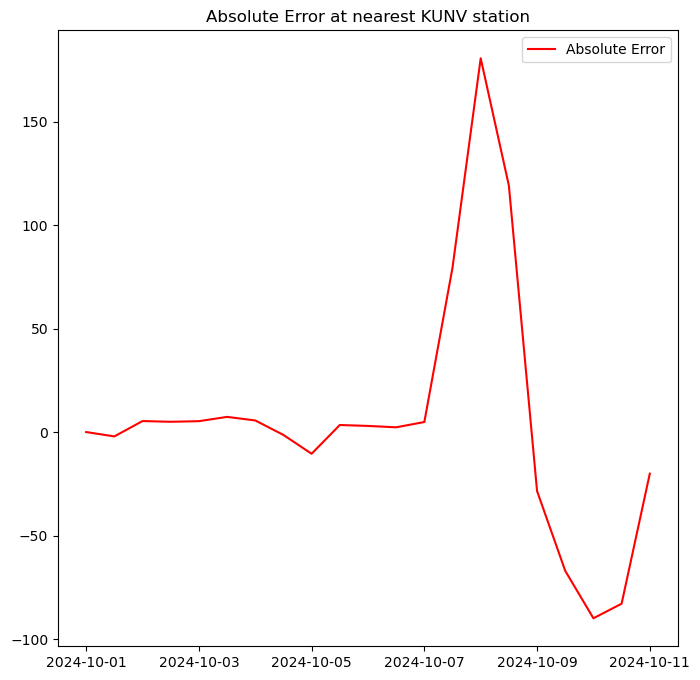

In [33]:
n=0
fullrun = []

while n <= 20:
    ghinit = gh[n]
    forecastinit = forecastfull[n]
    ghadd = ghinit - forecastinit
    fullrun.append(ghadd)
    n=n+1

ghabserror = xr.concat(fullrun, dim = 'valid_time')

errorvalues = ghabserror.values
kunv = ghabserror.sel(latitude = 40, longitude = -77 , method='nearest', tolerance=50)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.plot(valid_time.values, kunv, color='r', label='Absolute Error')
ax.legend()
ax.set_title('Absolute Error at nearest KUNV station')
plt.show()

## Repeat for the mean over multiple forecast hours (6-60) (66-144) (152,240)
#### take mean of abs error at every time and graph it

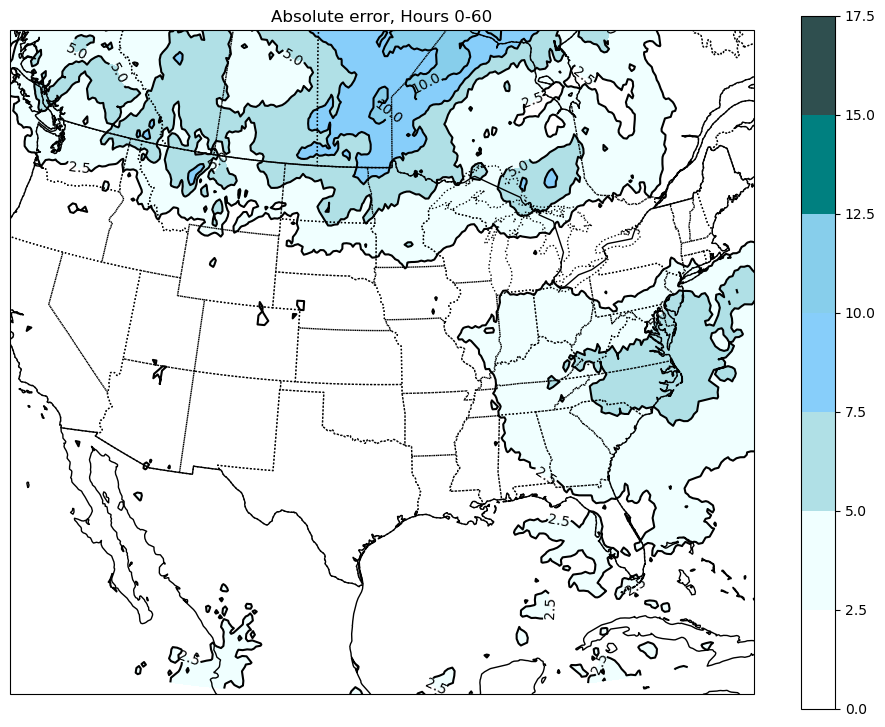

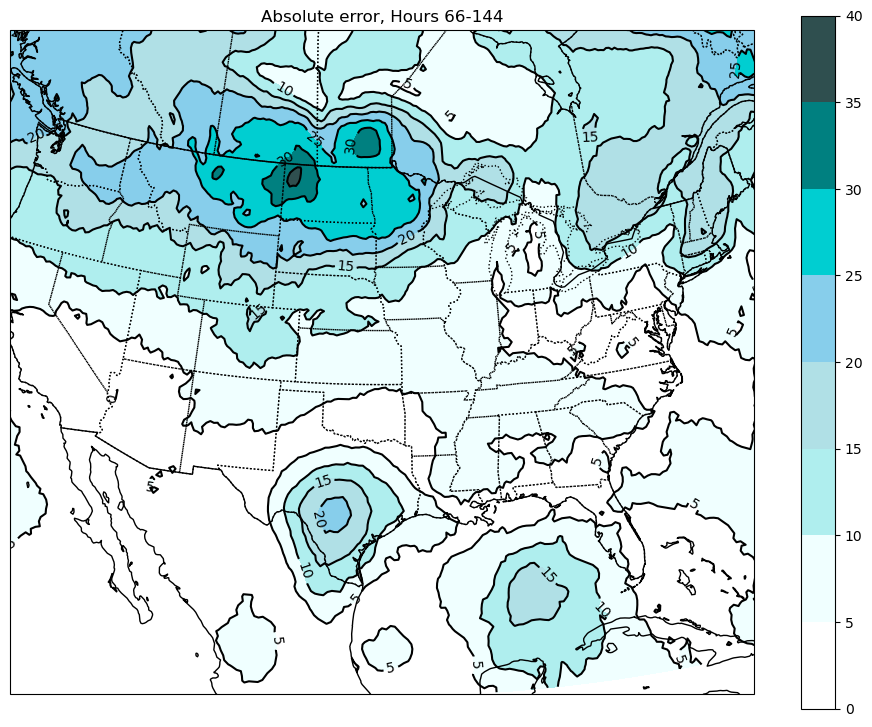

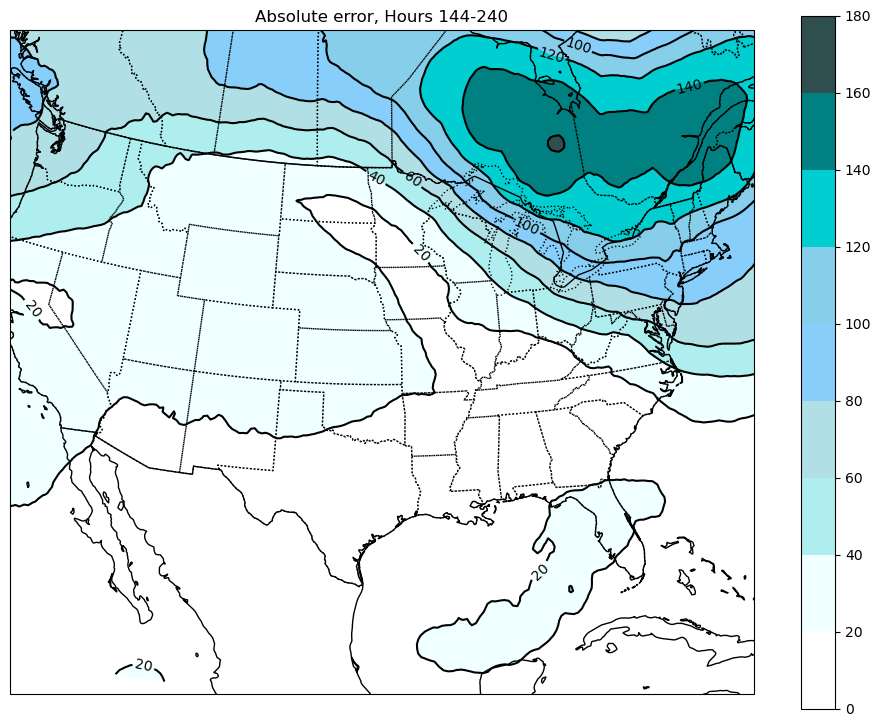

In [34]:
abserrorint = ghabserror.astype('int')
abserrorint = abs(abserrorint)

shortrange = abserrorint[0:5]
shortrange = shortrange.mean(dim = 'valid_time')

midrange = abserrorint[6:11]
midrange = midrange.mean(dim = 'valid_time')

longrange = abserrorint[12:]
longrange = longrange.mean(dim = 'valid_time')

custom_cmap2 = ListedColormap(['white', 'azure', 'paleturquoise' ,'powderblue','lightskyblue', 'skyblue', 'darkturquoise', 'teal', 'darkslategrey'])

lat = abserrorint.latitude.values
lon = abserrorint.longitude.values
dataproj = ccrs.PlateCarree()

insert = shortrange

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection=ccrs.LambertConformal())
ax.set_extent([-117,-75,20,55], ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle=':')
ax.add_feature(cfeature.BORDERS.with_scale('50m'))

# Plot parameters
cs = ax.contour(lon, lat, insert, colors='k', transform=dataproj)
plt.clabel(cs)
ax.contourf(lon, lat, insert, cmap = custom_cmap2 ,transform=dataproj)
color_map = ax.contourf(lon, lat, insert, cmap = custom_cmap2 ,transform=dataproj)
ax.set_title('Absolute error, Hours 0-60')
plt.colorbar(color_map, ax=ax)

insert = midrange

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection=ccrs.LambertConformal())
ax.set_extent([-117,-75,20,55], ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle=':')
ax.add_feature(cfeature.BORDERS.with_scale('50m'))

# Plot parameters
cs = ax.contour(lon, lat, insert, colors='k', transform=dataproj)
plt.clabel(cs)
ax.contourf(lon, lat, insert, cmap = custom_cmap2 ,transform=dataproj)
color_map = ax.contourf(lon, lat, insert, cmap = custom_cmap2 ,transform=dataproj)
ax.set_title('Absolute error, Hours 66-144')
plt.colorbar(color_map, ax=ax)

insert = longrange

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection=ccrs.LambertConformal())
ax.set_extent([-117,-75,20,55], ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle=':')
ax.add_feature(cfeature.BORDERS.with_scale('50m'))

# Plot parameters
cs = ax.contour(lon, lat, insert, colors='k', transform=dataproj)
plt.clabel(cs)
ax.contourf(lon, lat, insert, cmap = custom_cmap2 ,transform=dataproj)
color_map = ax.contourf(lon, lat, insert, cmap = custom_cmap2 ,transform=dataproj)
ax.set_title('Absolute error, Hours 144-240')
plt.colorbar(color_map, ax=ax)

### CALCULATE THE ROOT SQUARED MEAN ERROR FOR EACH FORECAST ERROR

In [35]:
Hforecast0 = FastHerbie(newlist[0:], model="ifs", product="oper", fxx=[0], max_threads = 2)
df = H.inventory()
df.reference_time.unique()
ds4 = Hforecast0.xarray(ss)

ds = H.xarray(ss)
ds = ds.sortby(['latitude', 'longitude'])
ds = ds.sel(longitude=slice(-130, -60), latitude=slice(20,60))
timeplot = ds['time']

gh = ds['gh']
gh0 = gh[0]
gh72 = gh[6]
gh144 = gh[12]
gh240 = gh[18]
gh = gh.sortby(['time'])

Could not find 20/21 GRIB files.


In [36]:
Hforecast0 = FastHerbie(newlist[0:1], model="ifs", product="oper", fxx=[0,12,24,36,48,60,72,84,96,108,120,132,144,156,168,180,192,204,216,228,240], max_threads = 2)
df = H.inventory()
df.reference_time.unique()
ds6 = Hforecast0.xarray(ss)
df.reference_time.unique()
ds4 = ds4.sel(longitude=slice(-130, -60), latitude=slice(60,20))
ds6 = ds6.sel(longitude=slice(-130, -60), latitude=slice(60,20))

ghverif = ds4['gh']
ghfull = ds6['gh']
ghverif = ghverif.sel(longitude=slice(-130, -60), latitude=slice(60,20))
ghfull = ghfull.sel(longitude=slice(-130, -60), latitude=slice(60,20))

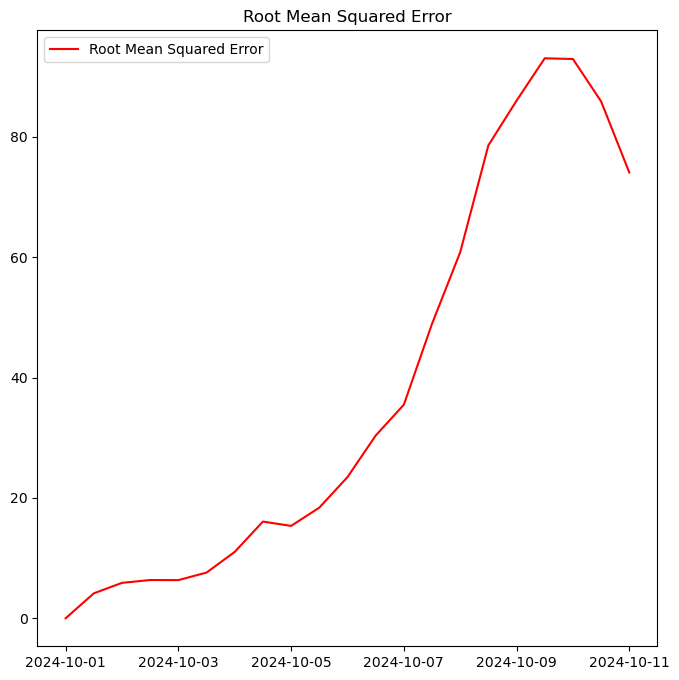

In [37]:
n = 0
RMSElist = []

while n <= 20:
    #erroradd = mean_squared_error(gh[n], ghfull[n]gh[n], ghfull[n], squared=False)
    # print(gh[n])
    erroradd = (np.array(ghfull[n])- np.array(ghverif[n]))**2
    errorsum = np.mean(erroradd, axis=None)

    errorfinal = np.sqrt(errorsum)
    RMSElist.append(errorfinal)
    n = n+1

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.plot(valid_time.values, RMSElist, color='r', label='Root Mean Squared Error')
ax.legend()
ax.set_title('Root Mean Squared Error')
plt.show()

## Analyze Multiple Runs

In [38]:
newlist2 = []
timelist2 = pd.date_range(start='2024-09-30',end='2024-10-11', freq='12h')

for n in timelist2:
    newlist2.append(n)

newlist2 = newlist2[1:22]

Hforecastfull2 = FastHerbie(newlist2[0:1], model="ifs", product="oper", fxx=[0,12,24,36,48,60,72,84,96,108,120,132,144,156,168,180,192,204,216,228,240])
df = H.inventory()
df.reference_time.unique()
ds5 = Hforecastfull2.xarray(ss)

df = Hforecastfull2.inventory()
df.reference_time.unique()

ds5 = ds5.sortby(['latitude', 'longitude'])
ds5 = ds5.sel(longitude=slice(-130, -60), latitude=slice(20,60))
latitude = ds5['latitude']
longitude = ds5['longitude']
valid_time2 = ds5['valid_time']

forecastfull5 = ds5['gh']
forecastfull5 = forecastfull.sortby(['latitude', 'longitude'])

n=0
fullrun2 = []

while n <= 20:
    ghinit2 = gh[n]
    forecastinit2 = forecastfull5[n]
    ghadd2 = ghinit2 - forecastinit2
    fullrun2.append(ghadd2)
    n=n+1

ghabserror2 = xr.concat(fullrun2, dim = 'valid_time')
test = ghabserror2['valid_time']

## Selecting a KUNV Grid Point

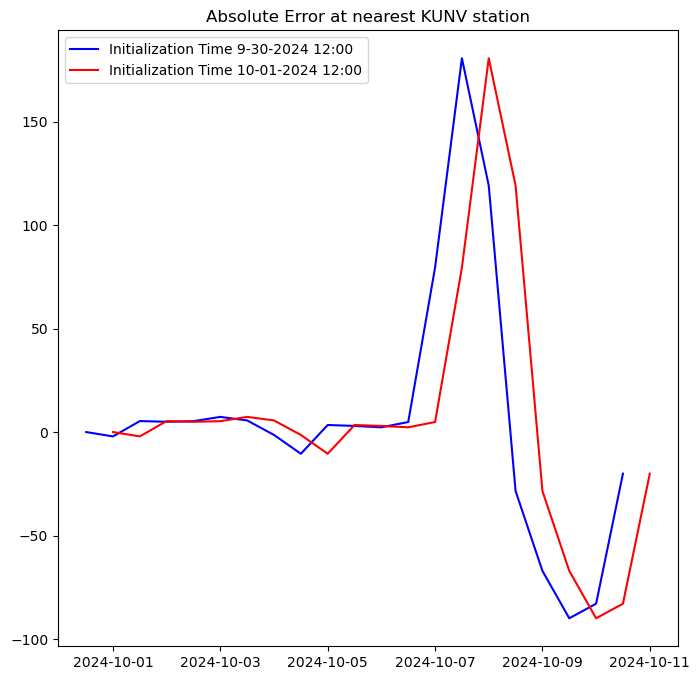

In [39]:
errorvalues2 =ghabserror2.values
kunv2 = ghabserror2.sel(latitude = 40, longitude = -77 , method='nearest', tolerance=50)


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.plot(valid_time2.values, kunv2, color='b', label='Initialization Time 9-30-2024 12:00')
ax.plot(valid_time.values, kunv, color='r', label='Initialization Time 10-01-2024 12:00')
ax.legend()
ax.set_title('Absolute Error at nearest KUNV station')
plt.show()

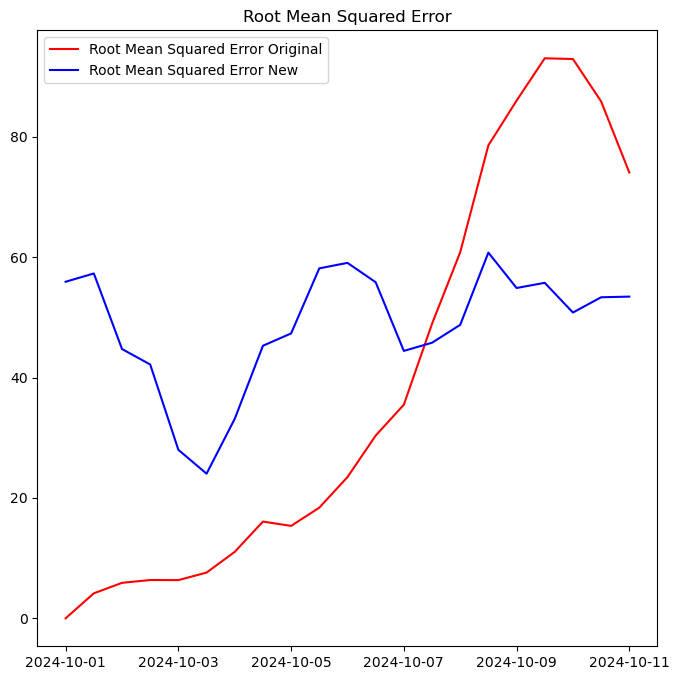

In [40]:
newlist2 = []
timelist2 = pd.date_range(start='2024-09-30',end='2024-10-11', freq='12h')

for n in timelist2:
    newlist2.append(n)

newlist2 = newlist2[1:22]
Hforecastfull2 = FastHerbie(newlist2[0:1], model="ifs", product="oper", fxx=[0,12,24,36,48,60,72,84,96,108,120,132,144,156,168,180,192,204,216,228,240])
Hforecastfull2

df = H.inventory()
df.reference_time.unique()

ds8 = Hforecastfull2.xarray(ss)
ds8

ghfull2 = ds8['gh']
ghfull2 = ghfull2.sel(longitude=slice(-130, -60), latitude=slice(60,20))

n = 0
RMSElist2 = []

while n <= 20:
    #erroradd = mean_squared_error(gh[n], ghfull[n]gh[n], ghfull[n], squared=False)
    # print(gh[n])
    erroradd = (np.array(ghfull2[n])- np.array(ghverif[n]))**2
    errorsum = np.mean(erroradd, axis=None)

    errorfinal = np.sqrt(errorsum)
    RMSElist2.append(errorfinal)
    n = n+1

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.plot(valid_time.values, RMSElist, color='r', label='Root Mean Squared Error Original')
ax.plot(valid_time.values, RMSElist2, color='b', label='Root Mean Squared Error New')
ax.legend()
ax.set_title('Root Mean Squared Error')
plt.show()

## GLORY-LEVEL TASKS
#### 1. Analyze multiple products: repeat the process for a different parameter (5 pts)

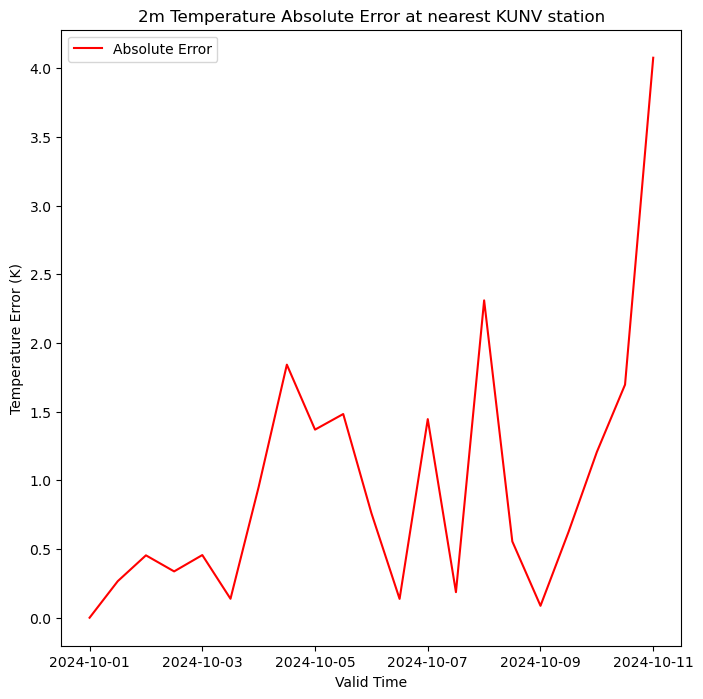

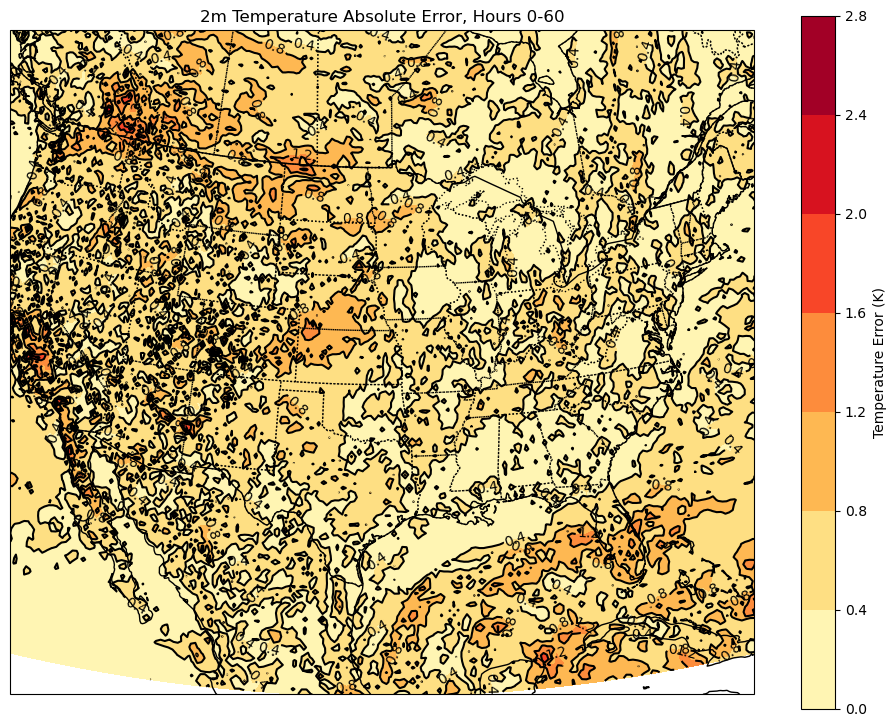

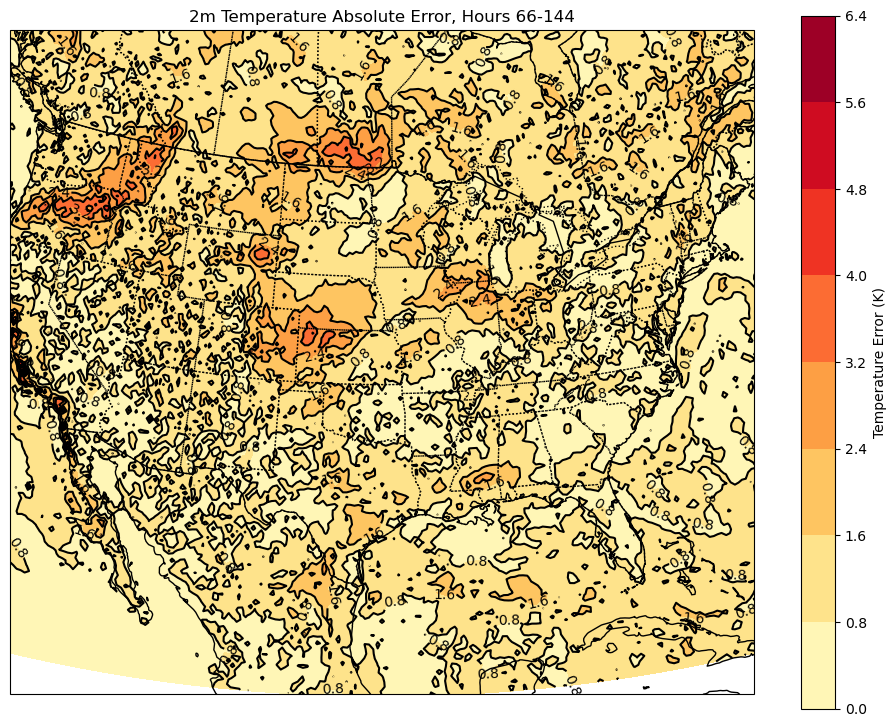

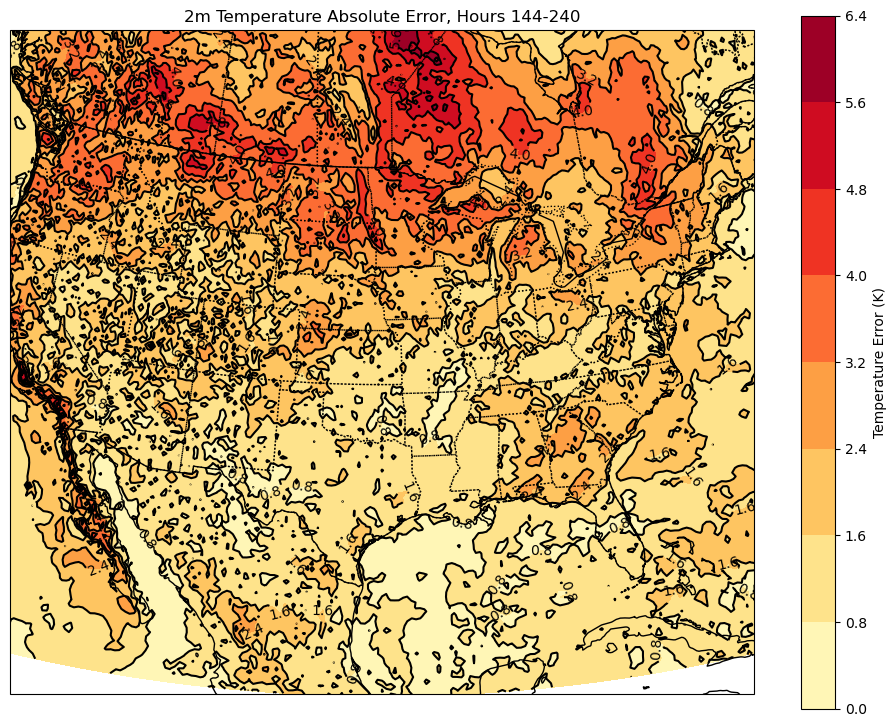

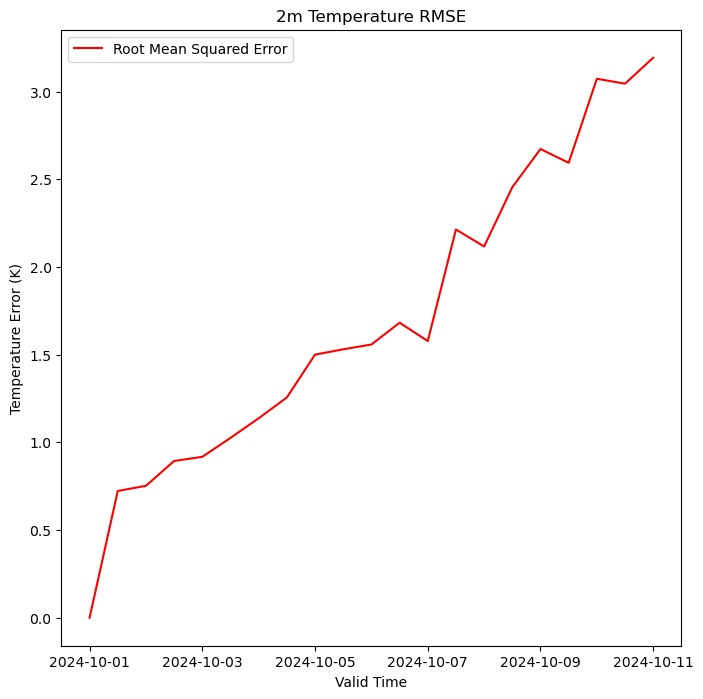

In [41]:
run = pd.Timestamp("now", tz="utc").replace(tzinfo=None).floor('24h')
timelist = pd.date_range(start='2024-10-01', end='2024-10-11', freq='12h')
newlist = list(timelist)

ss = r":2t:"

H = FastHerbie(timelist, model="ifs", product="oper", fxx=[0])
Hforecastfull = FastHerbie(newlist[:1], model="ifs", product="oper", fxx=[0,12,24,36,48,60,72,84,96,108,120,132,144,156,168,180,192,204,216,228,240])

ds3 = Hforecastfull.xarray(ss)
ds3 = ds3.sortby(['latitude', 'longitude'])
ds3 = ds3.sel(longitude=slice(-130, -60), latitude=slice(20,60))

Hforecast0 = FastHerbie(newlist[:21], model="ifs", product="oper", fxx=[0], max_threads=2)
ds4 = Hforecast0.xarray(ss)
ds4 = ds4.sortby(['latitude', 'longitude'])
ds4 = ds4.sel(longitude=slice(-130, -60), latitude=slice(20,60))

latitude = ds3['latitude']
longitude = ds3['longitude']
valid_time = ds3['valid_time']
forecastfull = ds3['t2m']
tempverif = ds4['t2m']

n = 0
fullrun = []
while n < min(len(forecastfull), len(tempverif)):
    tempinit = tempverif[n]
    forecastinit = forecastfull[n]
    tempadd = abs(tempinit - forecastinit)
    fullrun.append(tempadd)
    n += 1

tempabserror = xr.concat(fullrun, dim='valid_time')

kunv = tempabserror.sel(latitude=40, longitude=-77, method='nearest', tolerance=50)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.plot(valid_time.values[:len(kunv)], kunv, color='r', label='Absolute Error')
ax.legend()
ax.set_title('2m Temperature Absolute Error at nearest KUNV station')
ax.set_ylabel('Temperature Error (K)')
ax.set_xlabel('Valid Time')
plt.show()

temperrorint = tempabserror.astype('float')

shortrange = temperrorint[0:5]
shortrange = shortrange.mean(dim='valid_time')

midrange = temperrorint[6:11]
midrange = midrange.mean(dim='valid_time')

longrange = temperrorint[12:]
longrange = longrange.mean(dim='valid_time')

def plot_error_map(error_data, title):
    fig = plt.figure(figsize=(12,9))
    ax = fig.add_subplot(111, projection=ccrs.LambertConformal())
    ax.set_extent([-117,-75,20,55], ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
    ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle=':')
    ax.add_feature(cfeature.BORDERS.with_scale('50m'))
    
    dataproj = ccrs.PlateCarree()
    cs = ax.contour(longitude, latitude, error_data, colors='k', transform=dataproj)
    plt.clabel(cs)
    color_map = ax.contourf(longitude, latitude, error_data, cmap='YlOrRd', transform=dataproj)
    ax.set_title(title)
    plt.colorbar(color_map, ax=ax, label='Temperature Error (K)')
    plt.show()

plot_error_map(shortrange, '2m Temperature Absolute Error, Hours 0-60')
plot_error_map(midrange, '2m Temperature Absolute Error, Hours 66-144')
plot_error_map(longrange, '2m Temperature Absolute Error, Hours 144-240')

n = 0
RMSElist = []
while n < min(len(forecastfull), len(tempverif)):
    forecast_array = np.array(forecastfull[n])
    verif_array = np.array(tempverif[n])
    
    if forecast_array.shape == verif_array.shape:
        erroradd = (forecast_array - verif_array)**2
        errorsum = np.mean(erroradd, axis=None)
        errorfinal = np.sqrt(errorsum)
        RMSElist.append(errorfinal)
    else:
        print(f"Shape mismatch at hour {n}")
    n += 1

if RMSElist:
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    ax.plot(valid_time.values[:len(RMSElist)], RMSElist, color='r', label='Root Mean Squared Error')
    ax.legend()
    ax.set_title('2m Temperature RMSE')
    ax.set_ylabel('Temperature Error (K)')
    ax.set_xlabel('Valid Time')
    plt.show()
else:
    print("No valid RMSE calculations were performed due to shape mismatches")

#### 2. Analyze a different model (e.g. ECMWF AI, GFS) and compare the results (10 pts)
* Choose another model and repeat the process. Create plots that showcase the
differences in accuracy between the models.

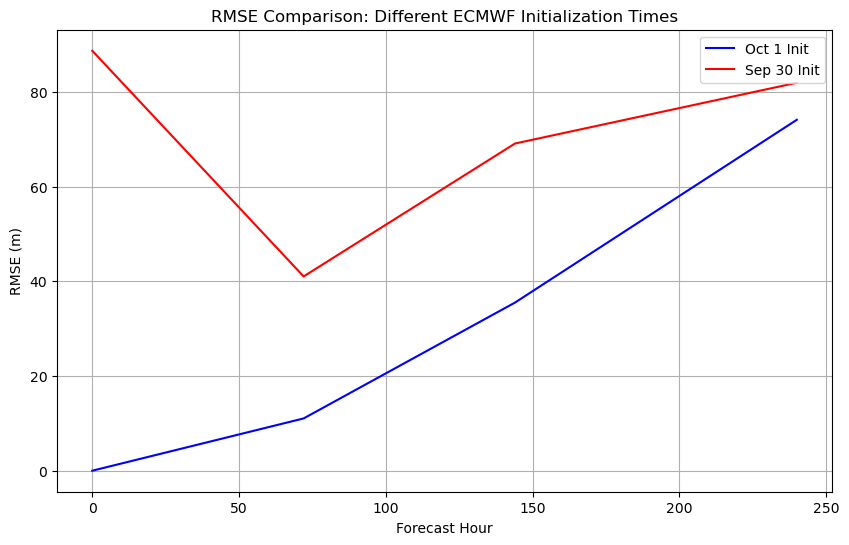

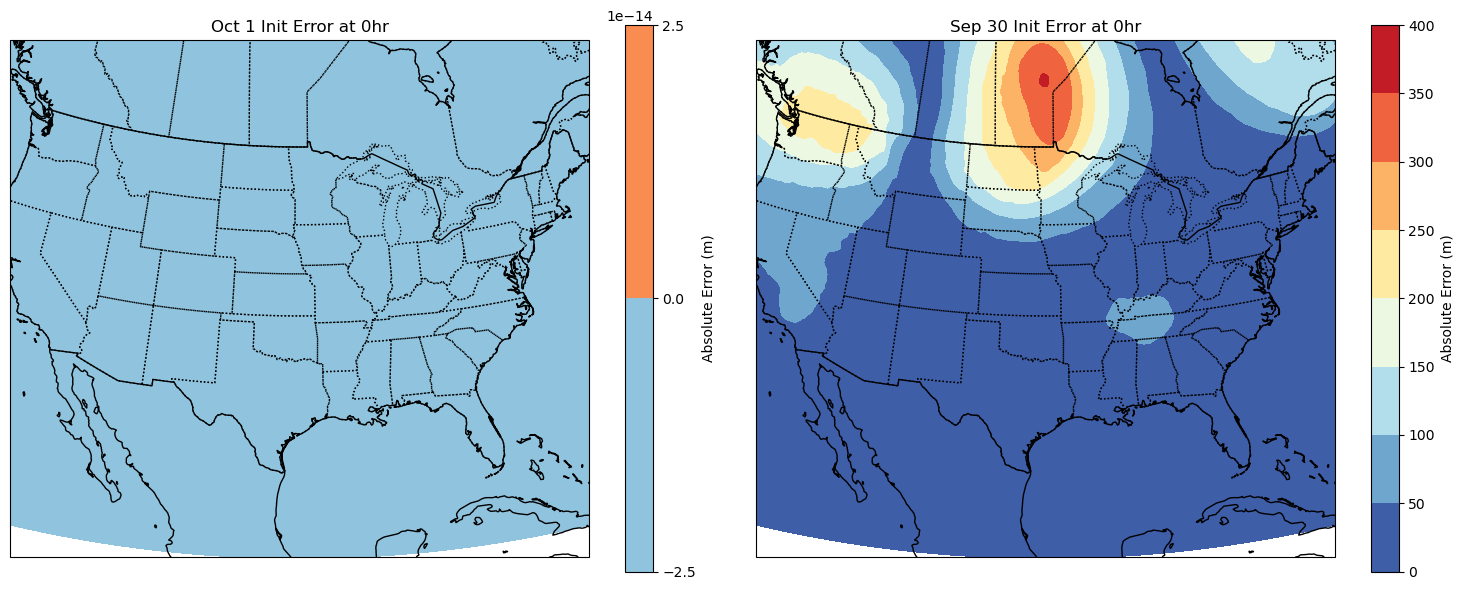

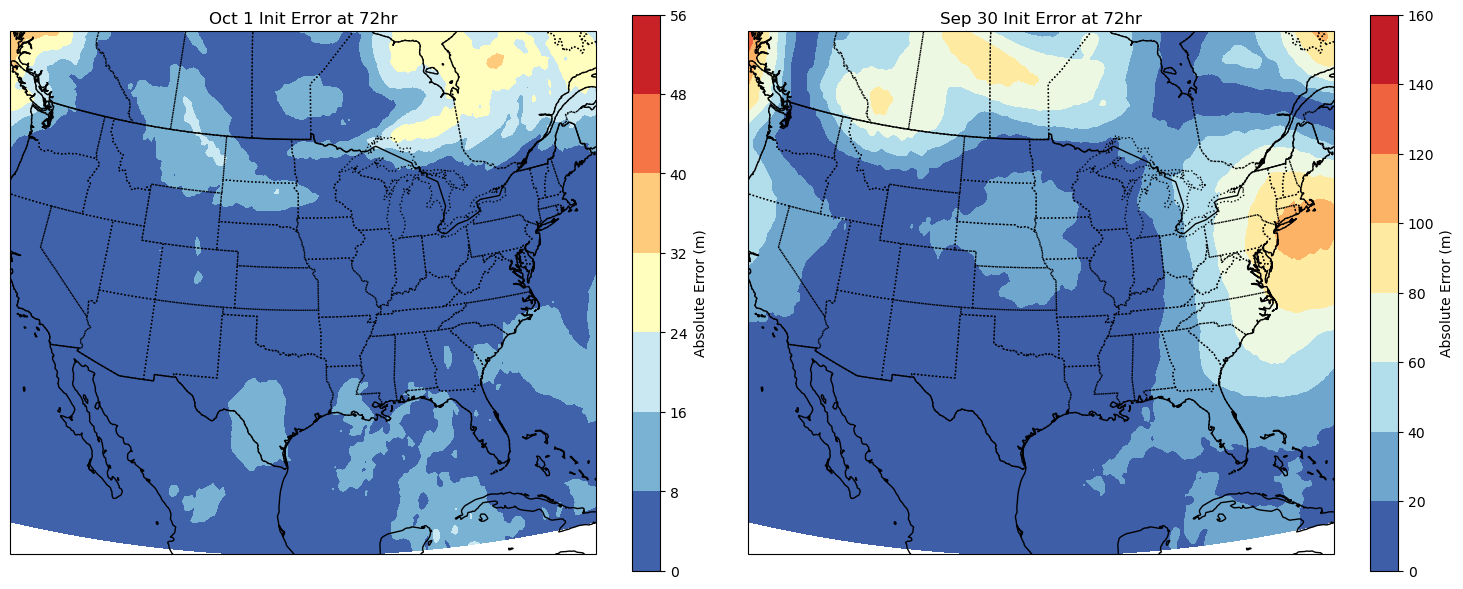

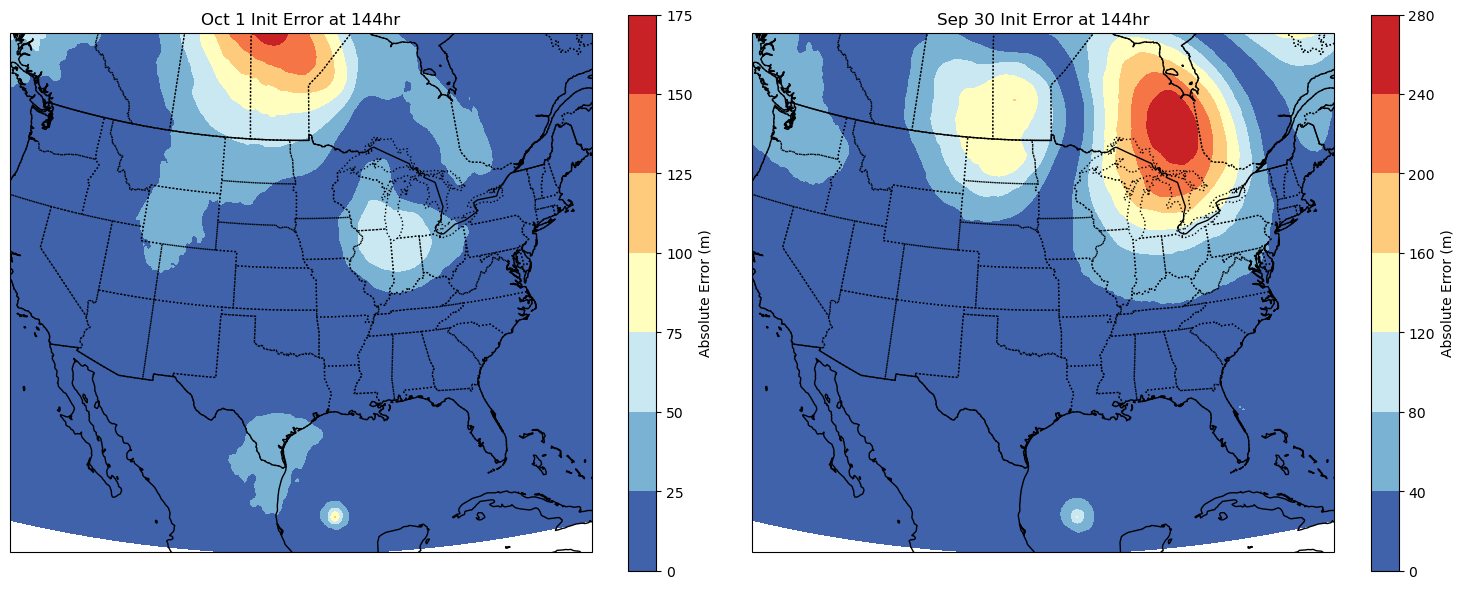

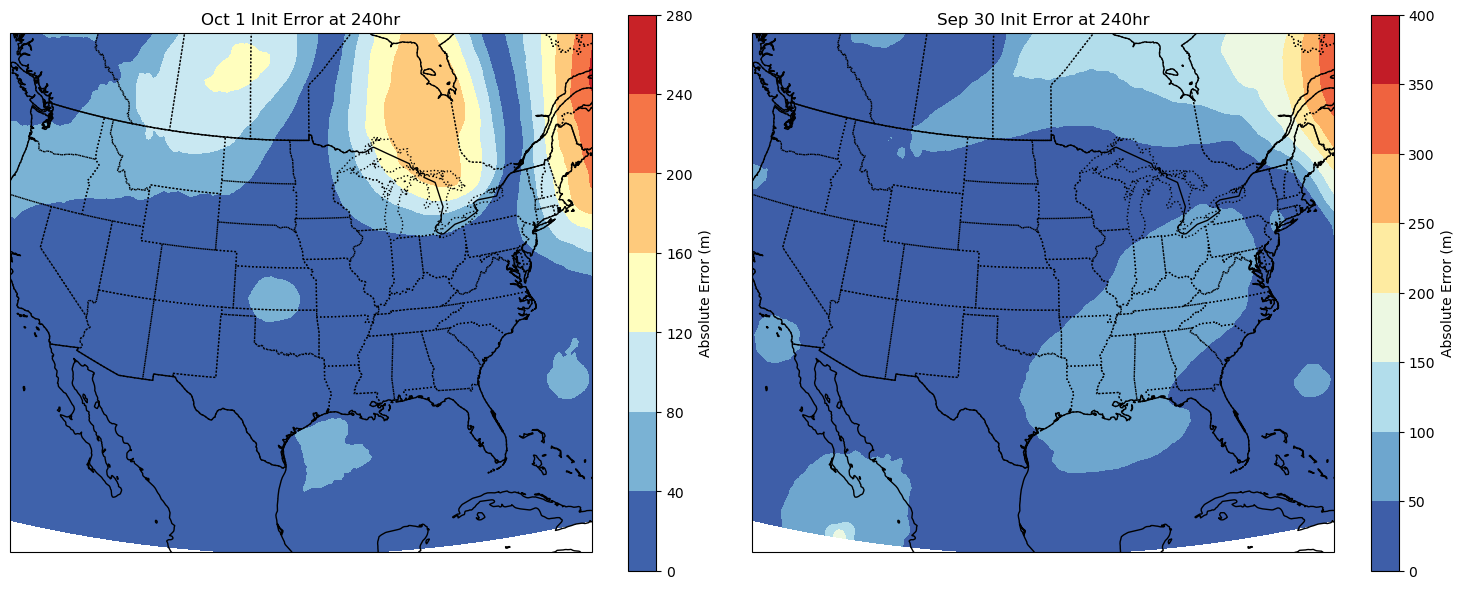

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

run_date1 = "2024-10-01"
run_date2 = "2024-09-30"
forecast_hours = [0, 72, 144, 240]

def get_model_data(run_date, hours):
    H = FastHerbie([run_date], model="ifs", product="oper", fxx=hours)
    ds = H.xarray(":gh:500:")
    ds = ds.where((ds.latitude >= 20) & (ds.latitude <= 60) & 
                  (ds.longitude >= -130) & (ds.longitude <= -60), drop=True)
    return ds

def get_verification_data(valid_times):
    H = FastHerbie(valid_times, model="ifs", product="oper", fxx=[0])
    ds = H.xarray(":gh:500:")
    ds = ds.where((ds.latitude >= 20) & (ds.latitude <= 60) & 
                  (ds.longitude >= -130) & (ds.longitude <= -60), drop=True)
    return ds

def plot_error_maps(gh1, gh2, gh_verif, hour_idx, hour):
    if hour_idx >= len(gh1) or hour_idx >= len(gh2) or hour_idx >= len(gh_verif):
        return
        
    error1 = abs(gh1[hour_idx] - gh_verif[hour_idx])
    error2 = abs(gh2[hour_idx] - gh_verif[hour_idx])
    
    if np.isnan(error1).all() or np.isnan(error2).all():
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), 
                                  subplot_kw={'projection': ccrs.LambertConformal()})
    
    for ax in [ax1, ax2]:
        ax.set_extent([-117, -75, 20, 55], ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
        ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle=':')
        ax.add_feature(cfeature.BORDERS.with_scale('50m'))
    
    try:
        cs1 = ax1.contourf(gh1.longitude, gh1.latitude, error1, 
                          transform=ccrs.PlateCarree(), cmap='RdYlBu_r')
        plt.colorbar(cs1, ax=ax1, label='Absolute Error (m)')
        ax1.set_title(f'Oct 1 Init Error at {hour}hr')
        
        cs2 = ax2.contourf(gh2.longitude, gh2.latitude, error2, 
                          transform=ccrs.PlateCarree(), cmap='RdYlBu_r')
        plt.colorbar(cs2, ax=ax2, label='Absolute Error (m)')
        ax2.set_title(f'Sep 30 Init Error at {hour}hr')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        pass

def main():
    ds_ecmwf1 = get_model_data(run_date1, forecast_hours)
    gh1 = ds_ecmwf1['gh']
    ds_ecmwf2 = get_model_data(run_date2, forecast_hours)
    gh2 = ds_ecmwf2['gh']
    
    verification_times = [pd.Timestamp(run_date1) + pd.Timedelta(hours=hr) 
                         for hr in forecast_hours]
    ds_verif = get_verification_data(verification_times)
    gh_verif = ds_verif['gh']
    
    rmse_run1 = []
    rmse_run2 = []
    for i in range(len(forecast_hours)):
        if i < len(gh1) and i < len(gh_verif):
            if not (np.isnan(gh1[i]).all() or np.isnan(gh_verif[i]).all()):
                rmse1 = np.sqrt(((gh1[i] - gh_verif[i]) ** 2).mean())
                rmse2 = np.sqrt(((gh2[i] - gh_verif[i]) ** 2).mean())
                rmse_run1.append(rmse1)
                rmse_run2.append(rmse2)
    
    if rmse_run1 and rmse_run2:
        plt.figure(figsize=(10, 6))
        plt.plot(forecast_hours[:len(rmse_run1)], rmse_run1, 'b-', 
                label='Oct 1 Init')
        plt.plot(forecast_hours[:len(rmse_run2)], rmse_run2, 'r-', 
                label='Sep 30 Init')
        plt.xlabel('Forecast Hour')
        plt.ylabel('RMSE (m)')
        plt.title('RMSE Comparison: Different ECMWF Initialization Times')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    for i, hour in enumerate(forecast_hours):
        plot_error_maps(gh1, gh2, gh_verif, i, hour)

if __name__ == "__main__":
    main()

#### 3. Analyze multiple runs (10 pts)
* For each forecast hour, download and verify data from ten consecutive model runs
* Re-generate each of the required MS 2 plots, showing the average error for each forecast hour

/tmp/ipykernel_779950/3766175384.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  init_times = pd.date_range(start=start_date, periods=10, freq='12H')


RMSE values: ['0.00', '11.04', '35.50', '74.08']
RMSE values: ['0.00', '9.60', '25.27', '80.37']
RMSE values: ['0.00', '9.74', '20.88', '92.37']
RMSE values: ['0.00', '9.34', '24.34', '84.55']
👨🏻‍🏭 Created directory: [/home/meteo/eez5034/data/ifs/20241013]
RMSE values: ['0.00', '12.20', '21.69', '79.25']
RMSE values: ['0.00', '14.39', '32.62', '81.49']
👨🏻‍🏭 Created directory: [/home/meteo/eez5034/data/ifs/20241014]
RMSE values: ['0.00', '10.41', '24.25', '48.45']
RMSE values: ['0.00', '13.73', '21.94', '59.86']
👨🏻‍🏭 Created directory: [/home/meteo/eez5034/data/ifs/20241015]
RMSE values: ['0.00', '12.74', '21.11', '79.56']
RMSE values: ['0.00', '15.00', '44.76', '100.46']


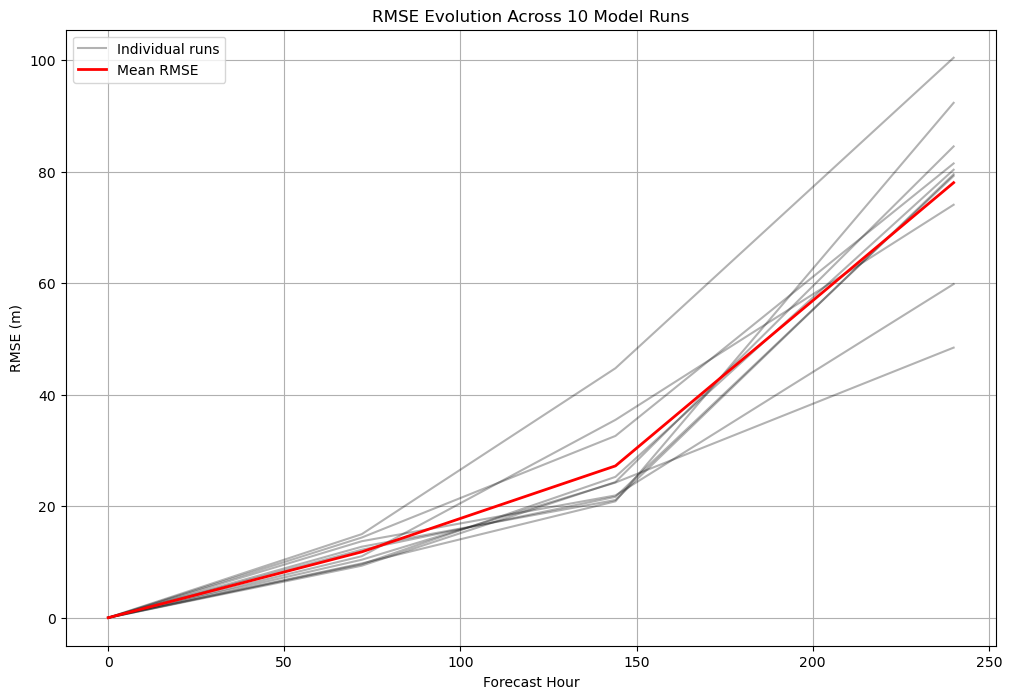


Generating mean error map for 0hr forecast


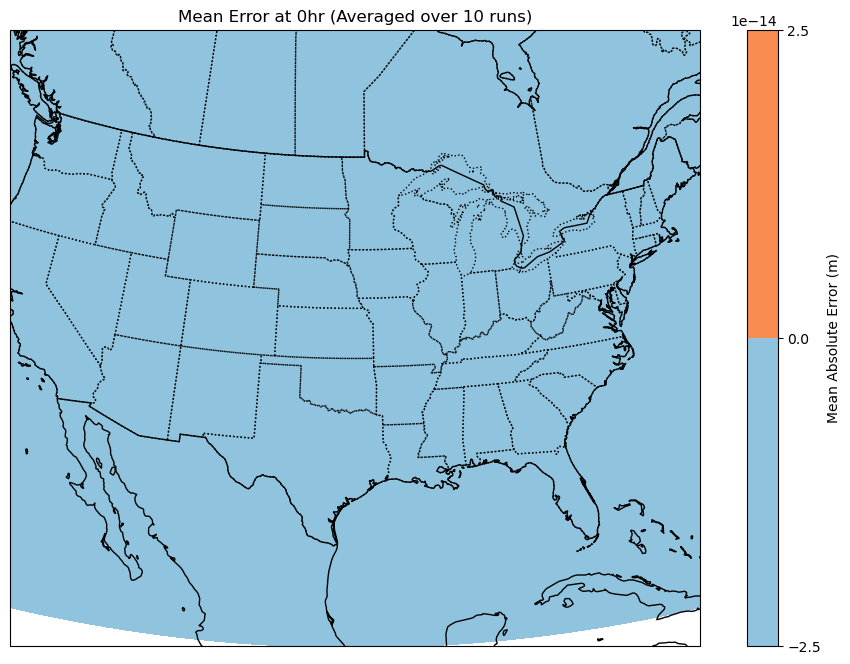


Generating mean error map for 72hr forecast


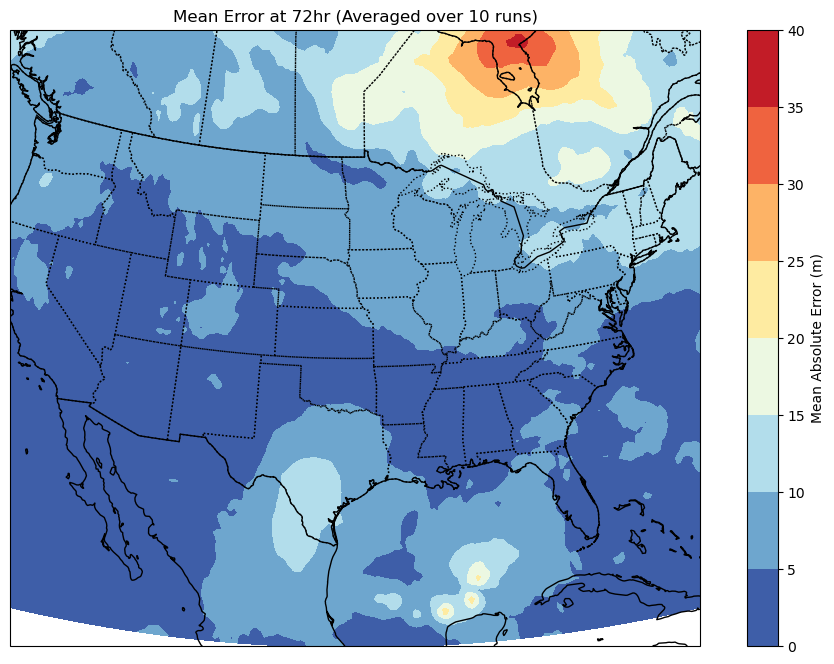


Generating mean error map for 144hr forecast


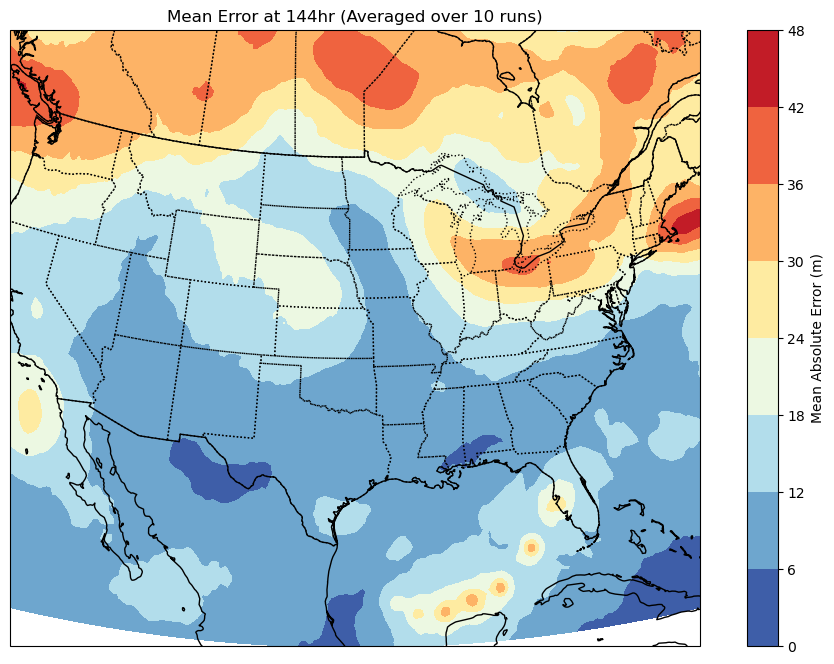


Generating mean error map for 240hr forecast


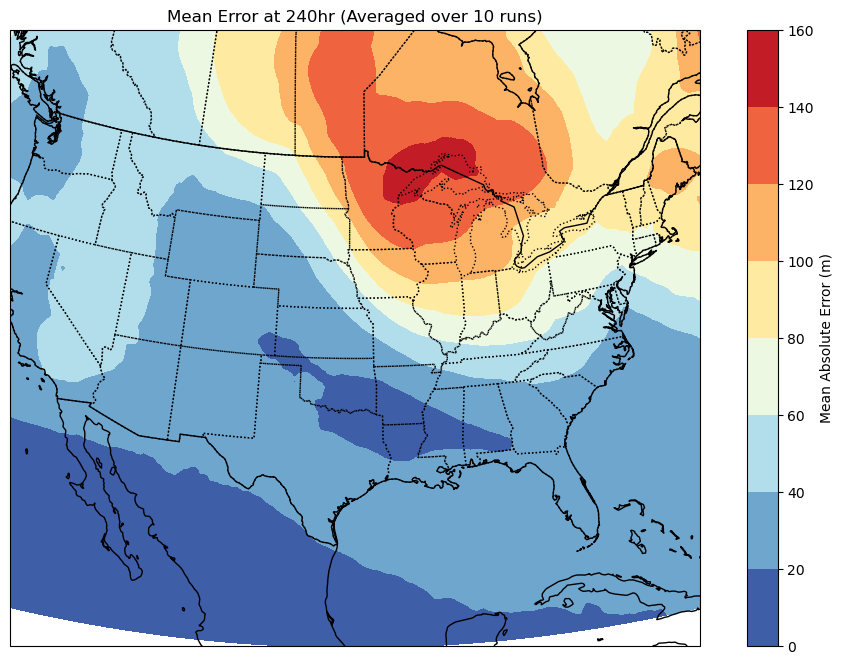


Summary Statistics:
----------------------------------------
Mean RMSE by forecast hour:
0hr: 0.00 meters
72hr: 11.82 meters
144hr: 27.23 meters
240hr: 78.04 meters

RMSE spread (std dev) by forecast hour:
0hr: ±0.00 meters
72hr: ±1.98 meters
144hr: ±7.50 meters
240hr: ±14.12 meters


In [43]:
start_date = "2024-10-01"
forecast_hours = [0, 72, 144, 240]

init_times = pd.date_range(start=start_date, periods=10, freq='12H')

def get_model_data(run_date, hours):
    H = FastHerbie([run_date], model="ifs", product="oper", fxx=hours)
    ds = H.xarray(":gh:500:")
    ds = ds.where((ds.latitude >= 20) & (ds.latitude <= 60) & (ds.longitude >= -130) & (ds.longitude <= -60), drop=True)
    return ds

def get_verification_data(valid_times):
    H = FastHerbie(valid_times, model="ifs", product="oper", fxx=[0])
    ds = H.xarray(":gh:500:")
    ds = ds.where((ds.latitude >= 20) & (ds.latitude <= 60) & (ds.longitude >= -130) & (ds.longitude <= -60), drop=True)
    return ds

all_rmse = []
all_errors = []

for init_time in init_times:    
    ds_forecast = get_model_data(init_time, forecast_hours)
    gh_forecast = ds_forecast['gh']
    
    verification_times = [init_time + pd.Timedelta(hours=hr) for hr in forecast_hours]
    ds_verif = get_verification_data(verification_times)
    gh_verif = ds_verif['gh']
    
    run_rmse = []
    run_errors = []
    for i in range(len(forecast_hours)):
        error = abs(gh_forecast[i] - gh_verif[i])
        rmse = np.sqrt((error ** 2).mean())
        run_rmse.append(rmse)
        run_errors.append(error)
    
    all_rmse.append(run_rmse)
    all_errors.append(run_errors)
    print(f"RMSE values: {[f'{x:.2f}' for x in run_rmse]}")

all_rmse = np.array(all_rmse)

plt.figure(figsize=(12, 8))
for i in range(len(init_times)):
    plt.plot(forecast_hours, all_rmse[i], 'k-', alpha=0.3, label='Individual runs' if i == 0 else None)

mean_rmse = np.mean(all_rmse, axis=0)
plt.plot(forecast_hours, mean_rmse, 'r-', linewidth=2, label='Mean RMSE')

plt.xlabel('Forecast Hour')
plt.ylabel('RMSE (m)')
plt.title('RMSE Evolution Across 10 Model Runs')
plt.legend()
plt.grid(True)
plt.show()

def plot_mean_error_map(errors, hour, hour_idx):
    mean_error = np.mean([run_errors[hour_idx] for run_errors in all_errors], axis=0)
    
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.LambertConformal())
    ax.set_extent([-117, -75, 20, 55], ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
    ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle=':')
    ax.add_feature(cfeature.BORDERS.with_scale('50m'))
    
    cs = ax.contourf(ds_forecast.longitude, ds_forecast.latitude, mean_error, transform=ccrs.PlateCarree(), cmap='RdYlBu_r')
    plt.colorbar(cs, ax=ax, label='Mean Absolute Error (m)')
    ax.set_title(f'Mean Error at {hour}hr (Averaged over {len(init_times)} runs)')
    plt.show()

for i, hour in enumerate(forecast_hours):
    print(f"\nGenerating mean error map for {hour}hr forecast")
    plot_mean_error_map(all_errors, hour, i)

# statistics
print("\nSummary Statistics:")
print("-" * 40)
print("Mean RMSE by forecast hour:")
for hour, rmse in zip(forecast_hours, mean_rmse):
    print(f"{hour}hr: {rmse:.2f} meters")

print("\nRMSE spread (std dev) by forecast hour:")
rmse_std = np.std(all_rmse, axis=0)
for hour, std in zip(forecast_hours, rmse_std):
    print(f"{hour}hr: ±{std:.2f} meters")

#### 4. Compare the model run to climatology (15 pts)
* Find a suitable climatology dataset and re-grid it to match your model’s grid
* Using the same procedure with which you verified your model data, verify the
climatology for each valid time. Then, calculate the RMSE for both the climatology and
model data. Create a line chart to show how these evolve over time. Does the model
ever become less accurate than climatology?

2024-12-13 21:38:56,038 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-12-13 21:38:56,039 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-12-13 21:38:56,039 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2024-12-13 21:38:56,040 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using t


Regridding climatology...

Hour 0:
Model RMSE: 0.00m
Climatology RMSE: 131.65m

Hour 72:
Model RMSE: 11.04m
Climatology RMSE: 81.11m

Hour 144:
Model RMSE: 35.50m
Climatology RMSE: 99.11m

Hour 240:
Model RMSE: 74.08m
Climatology RMSE: 89.55m


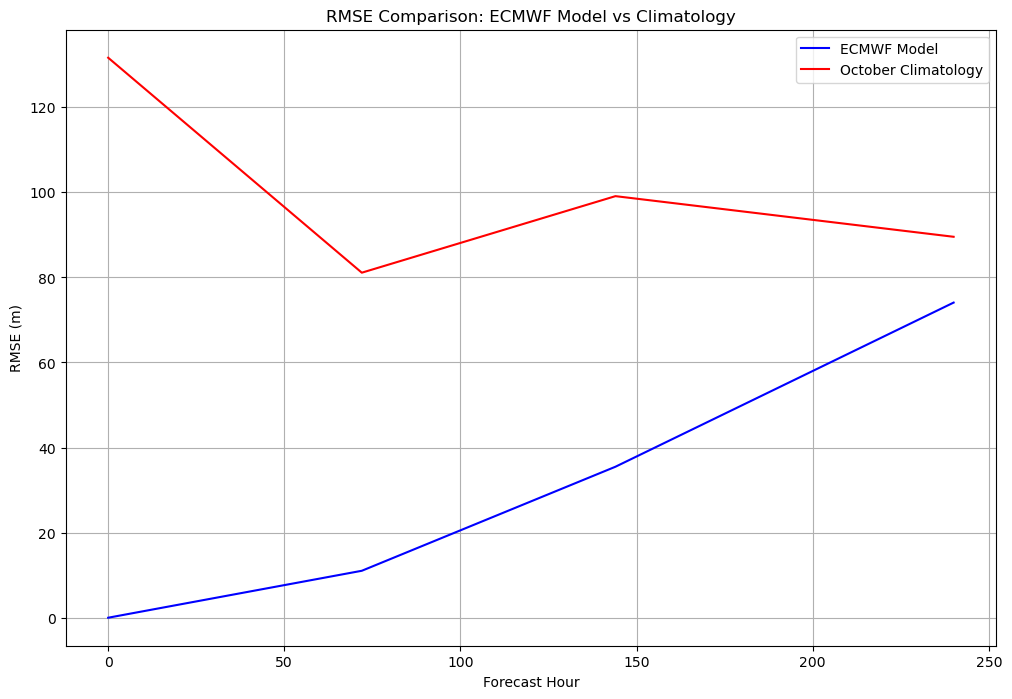


Generating error comparison for 0hr forecast


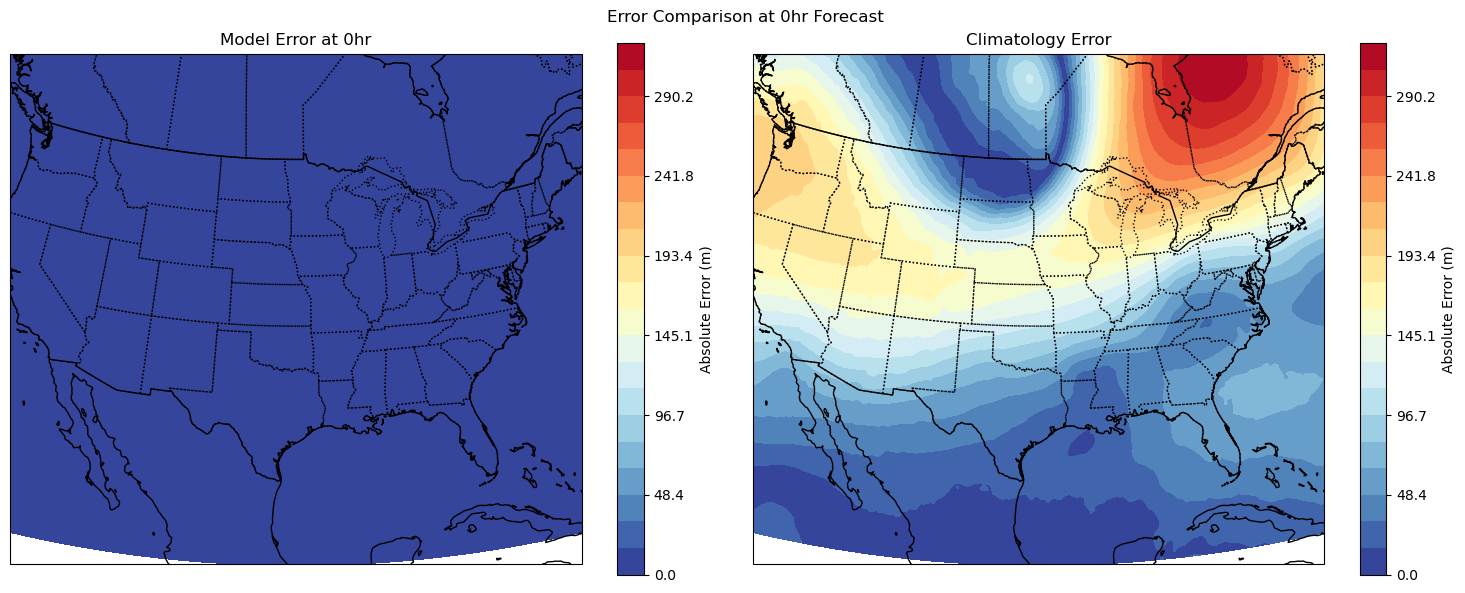


Generating error comparison for 72hr forecast


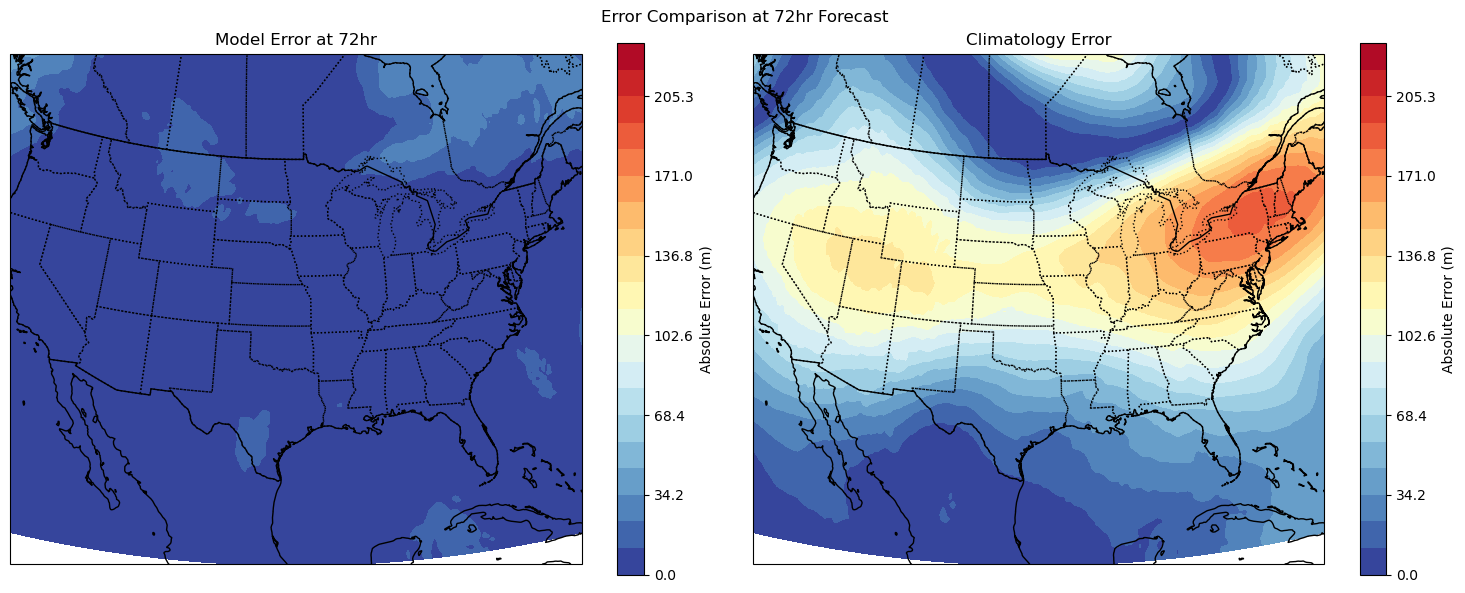


Generating error comparison for 144hr forecast


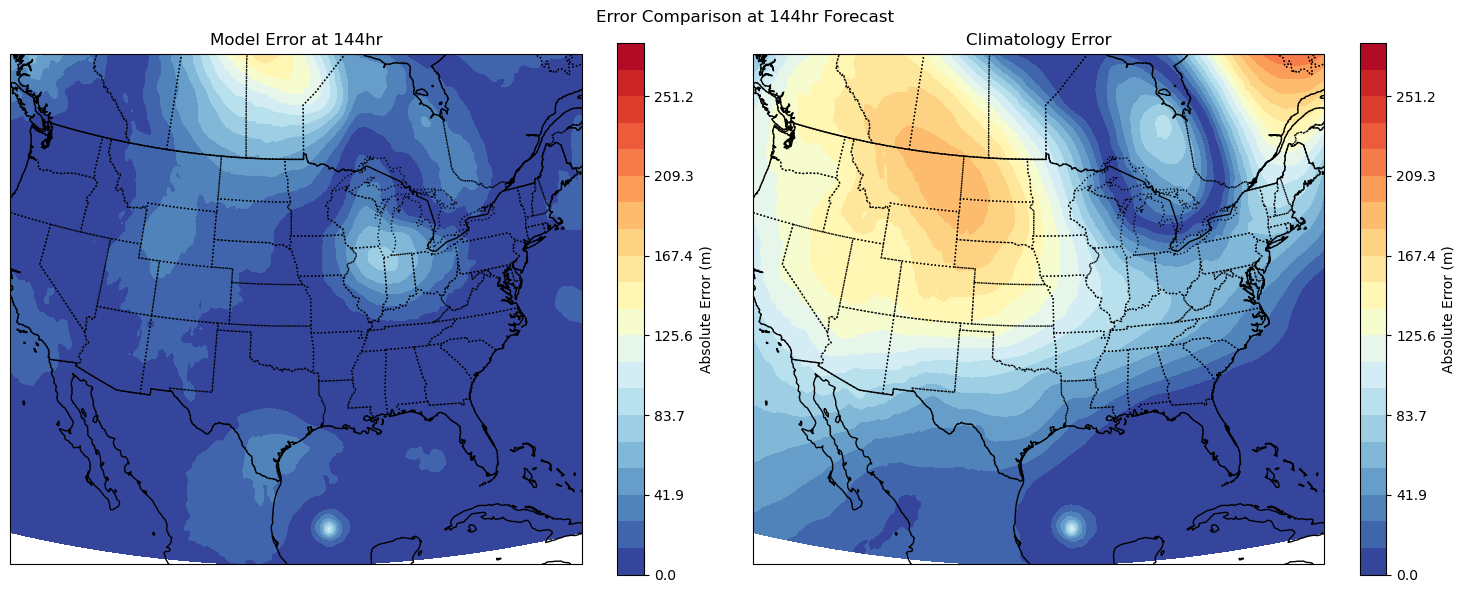


Generating error comparison for 240hr forecast


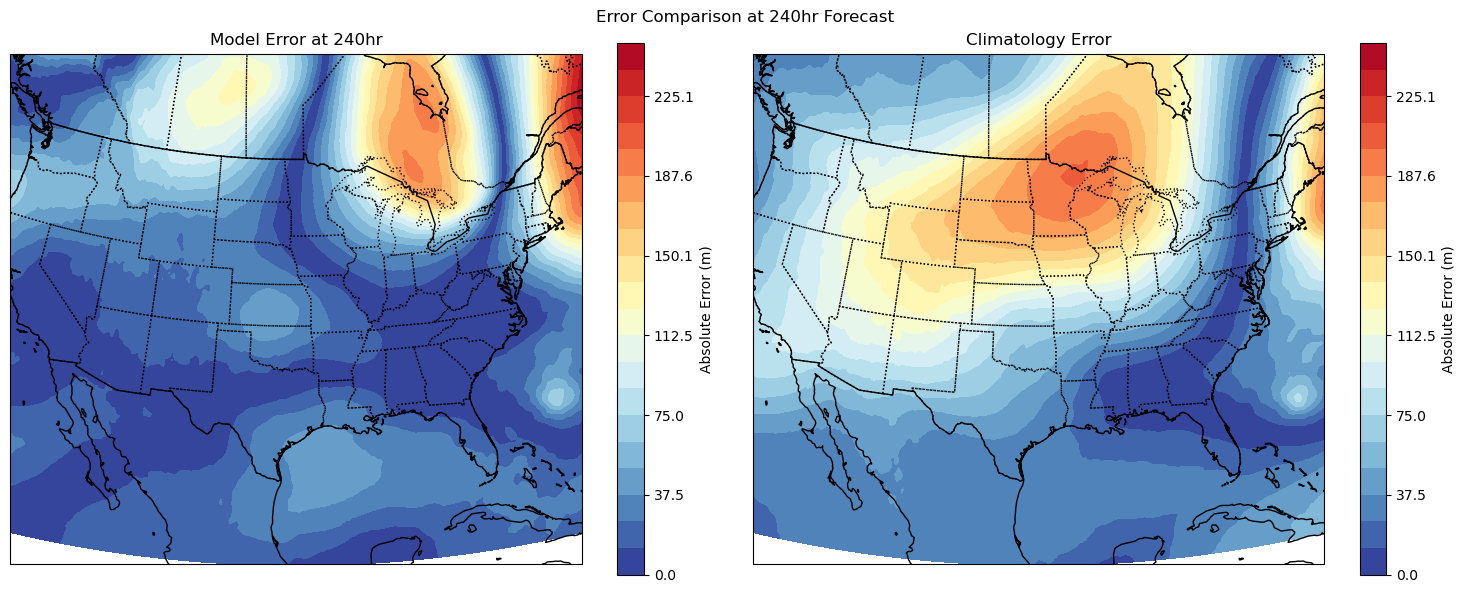


Summary Statistics:
----------------------------------------
Mean RMSE:
Model: 30.15 meters
Climatology: 100.35 meters

Does model beat climatology?
0hr: YES (Model: 0.00m, Clim: 131.65m)
72hr: YES (Model: 11.04m, Clim: 81.11m)
144hr: YES (Model: 35.50m, Clim: 99.11m)
240hr: YES (Model: 74.08m, Clim: 89.55m)


In [44]:
run_date = "2024-10-01"
forecast_hours = [0, 72, 144, 240]
domain = dict(longitude=slice(-130, -60), latitude=slice(20, 60))

era5_data_dir = "/home/meteo/dvn5267/meteo473_groupwork/group9/data/era5"
os.makedirs(era5_data_dir, exist_ok=True)

def download_era5_climatology():
    
    c = cdsapi.Client()
    
    target = f"{era5_data_dir}/era5_oct_clim.grib"
    
    c.retrieve(
        'reanalysis-era5-pressure-levels-monthly-means',
        {
            'product_type': 'monthly_averaged_reanalysis',
            'variable': 'geopotential',
            'pressure_level': '500',
            'year': list(range(1991, 2021)),
            'month': '10',
            'time': '00:00',
            'area': [60, -130, 20, -60],
            'format': 'grib',
        },
        target
    )
    return target

def process_climatology(ds_clim):
    if 'z' in ds_clim:
        clim_gh = ds_clim['z'] / 9.80665
    else:
        clim_gh = ds_clim['gh']
    
    return clim_gh.mean(dim='time')

def get_model_data(run_date, hours):
    H = FastHerbie([run_date], model="ifs", product="oper", fxx=hours)
    ds = H.xarray(":gh:500:")
    ds = ds.where((ds.latitude >= 20) & (ds.latitude <= 60) & 
                  (ds.longitude >= -130) & (ds.longitude <= -60), drop=True)
    return ds

def get_verification_data(valid_times):
    H = FastHerbie(valid_times, model="ifs", product="oper", fxx=[0])
    ds = H.xarray(":gh:500:")
    ds = ds.where((ds.latitude >= 20) & (ds.latitude <= 60) & 
                  (ds.longitude >= -130) & (ds.longitude <= -60), drop=True)
    return ds

clim_file = download_era5_climatology()
ds_clim = xr.open_dataset(clim_file, engine='cfgrib')
clim_mean = process_climatology(ds_clim)

ds_model = get_model_data(run_date, forecast_hours)
gh_model = ds_model['gh']

verification_times = [pd.Timestamp(run_date) + pd.Timedelta(hours=hr) for hr in forecast_hours]
ds_verif = get_verification_data(verification_times)
gh_verif = ds_verif['gh']

print("\nRegridding climatology...")
clim_regrid = clim_mean.interp(
    latitude=gh_model.latitude,
    longitude=gh_model.longitude
)

model_rmse = []
clim_rmse = []

for i in range(len(forecast_hours)):
    model_error = abs(gh_model[i] - gh_verif[i])
    clim_error = abs(clim_regrid - gh_verif[i])
    
    model_rmse.append(float(np.sqrt((model_error ** 2).mean())))
    clim_rmse.append(float(np.sqrt((clim_error ** 2).mean())))
    
    print(f"\nHour {forecast_hours[i]}:")
    print(f"Model RMSE: {model_rmse[-1]:.2f}m")
    print(f"Climatology RMSE: {clim_rmse[-1]:.2f}m")

plt.figure(figsize=(12, 8))
plt.plot(forecast_hours, model_rmse, 'b-', label='ECMWF Model')
plt.plot(forecast_hours, clim_rmse, 'r-', label='October Climatology')
plt.xlabel('Forecast Hour')
plt.ylabel('RMSE (m)')
plt.title('RMSE Comparison: ECMWF Model vs Climatology')
plt.legend()
plt.grid(True)
plt.show()

def plot_error_comparison(model_error, clim_error, hour):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6),
                                  subplot_kw={'projection': ccrs.LambertConformal()})
    
    for ax in [ax1, ax2]:
        ax.set_extent([-117, -75, 20, 55], ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
        ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle=':')
        ax.add_feature(cfeature.BORDERS.with_scale('50m'))
    
    model_max = float(model_error.max())
    clim_max = float(clim_error.max())
    max_error = max(model_max, clim_max)
    
    levels = np.arange(0, max_error + max_error/20, max_error/20)
    
    cs1 = ax1.contourf(gh_model.longitude, gh_model.latitude, model_error,
                       levels=levels, transform=ccrs.PlateCarree(), cmap='RdYlBu_r')
    plt.colorbar(cs1, ax=ax1, label='Absolute Error (m)')
    ax1.set_title(f'Model Error at {hour}hr')
    
    cs2 = ax2.contourf(gh_model.longitude, gh_model.latitude, clim_error,
                       levels=levels, transform=ccrs.PlateCarree(), cmap='RdYlBu_r')
    plt.colorbar(cs2, ax=ax2, label='Absolute Error (m)')
    ax2.set_title('Climatology Error')
    
    plt.suptitle(f'Error Comparison at {hour}hr Forecast')
    plt.tight_layout()
    plt.show()

# Compare
for i, hour in enumerate(forecast_hours):
    print(f"\nGenerating error comparison for {hour}hr forecast")
    model_error = abs(gh_model[i] - gh_verif[i])
    clim_error = abs(clim_regrid - gh_verif[i])
    plot_error_comparison(model_error, clim_error, hour)

# statistics
print("\nSummary Statistics:")
print("-" * 40)
print("Mean RMSE:")
print(f"Model: {np.mean(model_rmse):.2f} meters")
print(f"Climatology: {np.mean(clim_rmse):.2f} meters")
print("\nDoes model beat climatology?")
for hour, m_rmse, c_rmse in zip(forecast_hours, model_rmse, clim_rmse):
    better = "YES" if m_rmse < c_rmse else "NO"
    print(f"{hour}hr: {better} (Model: {m_rmse:.2f}m, Clim: {c_rmse:.2f}m)")